In [1]:
%run ../../utils/commonImports.py
%run ../../utils/tradingImports.py
%matplotlib inline

# Load data

In [2]:
features = ['vol2016', 'ac288', 'vol288', 'ac36', 'return', 'dv_36_288']
X_train, y_train, X_val, y_val, X_test, y_test = load_split("D:\\Dropbox\\My work\\krypl-project\\dataSplit\\return-01-loss-max-01-within-day")
X_train, X_val, X_test = X_train[features], X_val[features], X_test[features]

In [3]:
from sklearn.externals import joblib
from modeling.gridsearch import GridSearch

path = "D:\\Dropbox\\My work\\krypl-project\\models\\return-01-loss-max-01-within-day"
grid_search = joblib.load(f'{path}\\bayes_search.pkl')

# Prediction on validation set

In [4]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve

confusion_matrixes = []
precisions = []
recalls = []
for clf in grid_search.clfs:
    y_pred = clf.predict(X_val)
    confusion_matrixes.append(confusion_matrix(y_val, y_pred))
    precisions.append(precision_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))

# Precision - recall

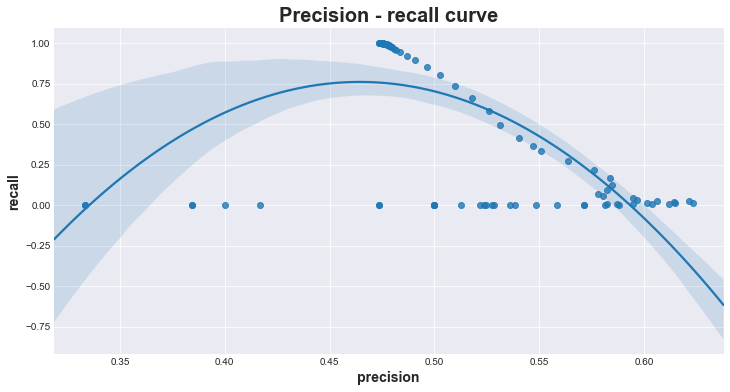

In [5]:
plt.figure(figsize=[12, 6])
sns.regplot(np.array(precisions), np.array(recalls), order=2)
plt.title('Precision - recall curve', fontproperties=title_font)
plt.xlabel('precision', fontproperties=axis_font)
plt.ylabel('recall', fontproperties=axis_font);

# ROC curve

In [6]:
def cm_parts(conf_mat):
    TN = conf_mat[0, 0]
    FN = conf_mat[1, 0]
    FP = conf_mat[0, 1]
    TP = conf_mat[1, 1]
    return TN, FN, FP, TP


def fpr(conf_mat):
    TN, FN, FP, TP = cm_parts(conf_mat)
    return FP / (FP + TN)

# TN = 1, FN = 2, FP = 3, TP = 4
y = [0, 0,  0, 1, 1, 1, 1, 1, 1, 1]
y_true = [0, 1, 1, 0, 0, 0, 1, 1, 1, 1]
conf_mat = confusion_matrix(y_true, y)
np.testing.assert_array_equal(conf_mat, np.array([[1, 3], 
                                                  [2, 4]]))
TN, FN, FP, TP = cm_parts(conf_mat)
assert TN == 1
assert FN == 2
assert FP == 3
assert TP == 4

assert fpr(conf_mat) == (3 / (3+1))

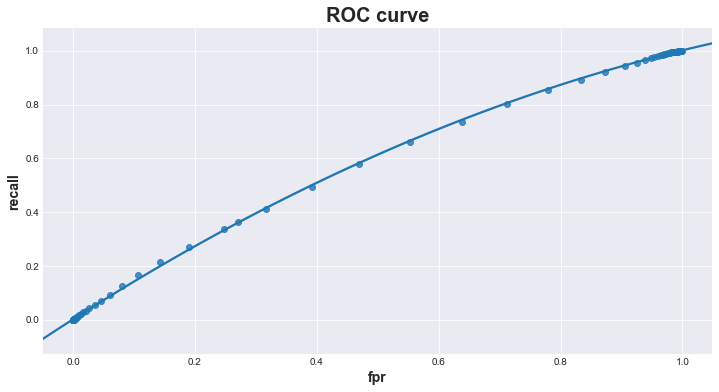

In [7]:
fprs = [fpr(conf_mat) for conf_mat in confusion_matrixes]
plt.figure(figsize=[12, 6])
sns.regplot(np.array(fprs), np.array(recalls), order=2)
plt.title('ROC curve', fontproperties=title_font)
plt.xlabel('fpr', fontproperties=axis_font)
plt.ylabel('recall', fontproperties=axis_font);

# Prediction probabilities

In [8]:
stats = pd.DataFrame({
        'precision': precisions,
        'recall': recalls,
        'fpr': fprs
    })

stats.sort_values('precision', ascending=False).head(50)

,precision,recall,fpr
66,0.6231,0.0150,0.0082
64,0.6212,0.0228,0.0125
68,0.6148,0.0102,0.0057
65,0.6141,0.0185,0.0105
69,0.6119,0.0084,0.0048
63,0.6061,0.0278,0.0163
70,0.6036,0.0069,0.0041
67,0.6013,0.0118,0.0070
62,0.5965,0.0338,0.0205
71,0.5947,0.0055,0.0034


In [9]:
clf = grid_search.clfs[66]

In [10]:
def group(_class):
    grouped = prob_df[['y_true', 'prob_bucket']].copy()\
        .query(f'y_true == {_class}')\
        .groupby('prob_bucket')\
        .count()\
        .reset_index()
    grouped.columns = ['prob_bucket', 'count']
    grouped['count_norm'] = grouped['count'] / grouped['count'].sum()
    return grouped
    
y_prob = clf.predict_proba(X_val)
prob_df = pd.DataFrame({'y_true': y_val, 'y_prob_1': y_prob[:, 1]})
prob_df['prob_bucket'] = np.floor(prob_df['y_prob_1'] * 10) / 10

grouped_true_1 = group(1)
grouped_true_0 = group(0)

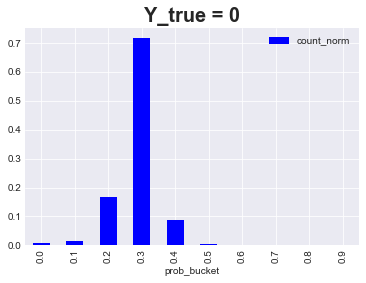

In [11]:
grouped_true_0.plot.bar('prob_bucket', 'count_norm', color='b')
plt.title('Y_true = 0', fontproperties=title_font);

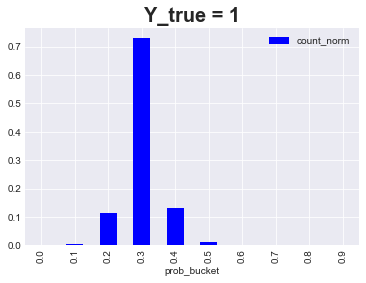

In [12]:
grouped_true_1.plot.bar('prob_bucket', 'count_norm', color='b')
plt.title('Y_true = 1', fontproperties=title_font);

### Test different thresholds

In [19]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve

confusion_matrixes = []
precisions = []
recalls = []
for thr in [i/100.0 for i in range(100)]:
    y_proba = clf.predict_proba(X_val)
    y_pred = np.array([int(proba > thr) for proba in y_proba[:, 1]])
    confusion_matrixes.append(confusion_matrix(y_val, y_pred))
    precisions.append(precision_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))

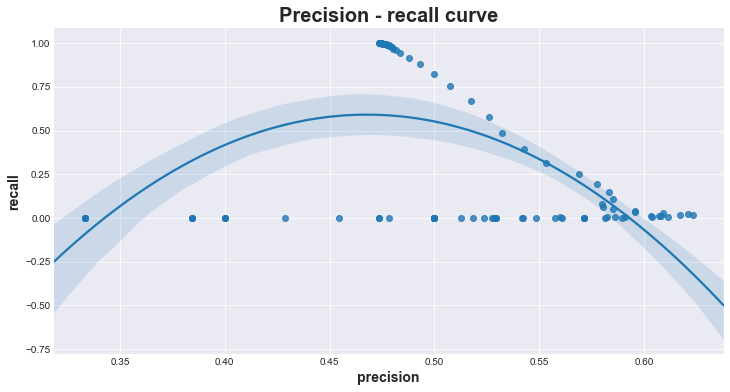

In [20]:
plt.figure(figsize=[12, 6])
sns.regplot(np.array(precisions), np.array(recalls), order=2)
plt.title('Precision - recall curve', fontproperties=title_font)
plt.xlabel('precision', fontproperties=axis_font)
plt.ylabel('recall', fontproperties=axis_font);

# Evaluation on test set

In [70]:
from sklearn.metrics import classification_report, confusion_matrix

def cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, columns=['predicted_0', 'predicted_1'], index=['true_0', 'true_1'])
    return cm


def eval(clf, X, y_true):
    y_pred = clf.predict(X)
    report = classification_report(y_true, y_pred)
    conf_matrix = cm(y_true, y_pred)
    print(conf_matrix, end='\n\n')
    print(f'Precison: %.3f' % precision_score(y_true, y_pred))
    print(f'Recall: %.3f' % recall_score(y_true, y_pred))
    print(f'FPR: %.3f' % fpr(conf_matrix.values))

In [71]:
eval(clf, X_val, y_val)

        predicted_0  predicted_1
true_0         3158          176
true_1        28080         3601

Precison: 0.953
Recall: 0.114
FPR: 0.053


In [72]:
eval(clf, X_test, y_test)

        predicted_0  predicted_1
true_0         4861          248
true_1        41592         5560

Precison: 0.957
Recall: 0.118
FPR: 0.049


In [73]:
joblib.dump(clf, f'{path}\\bayes_selected_01.pkl');

In [17]:
clf.

array([[7.38495329e-06, 6.87637684e-06, 7.18587951e-06, 1.42991791e+00,
        1.23505028e+00, 1.32361748e+00, 1.56654918e+00, 1.56654918e+00,
        1.44178273e+00, 2.64271493e+00, 3.44380541e+00, 1.82235219e+00,
        1.04282961e+00, 1.75472368e+00, 2.77990389e+00, 2.47383501e+00,
        2.91035329e+00],
       [1.54544586e-05, 1.53250635e-05, 1.53481079e-05, 1.27530655e+00,
        1.10065341e+00, 1.23901159e+00, 1.51182049e+00, 1.51182049e+00,
        1.36725279e+00, 2.85703996e+00, 3.26473514e+00, 1.58319921e+00,
        1.33883365e+00, 1.66090346e+00, 2.78570527e+00, 3.08880907e+00,
        2.77423002e+00]])